In [1]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras import Model
import tensorflow as tf

In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
import tensorflow as tf
config = tf.compat.v1.ConfigProto(gpu_options = 
                         tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.8)
# device_count = {'GPU': 1}
)
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(session)

In [4]:
train_dir = 'dataset/train_images'
val_dir = 'dataset/val_images'
test_dir = 'dataset/test_images'
train_dir2 = 'train'

#datagen = ImageDataGenerator(1./255)
train_generator = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir2,
    validation_split=0.2,
    batch_size=32,
    image_size=(64,64),
    seed=123,
    color_mode='rgb',
    subset = 'training'
)
val_generator = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir2,
    validation_split=0.2,
    batch_size=32,
    image_size=(64,64),
    seed=123,
    color_mode='rgb',
    subset = 'validation'
)
print(train_generator.class_names)

Found 8104 files belonging to 2 classes.
Using 6484 files for training.
Found 8104 files belonging to 2 classes.
Using 1620 files for validation.
['fake', 'real']


In [5]:
def inception_module(layer_in, f1,f2_in,f2_out,f3_in,f3_out,f4_out):
    #1x1
    conv1 = Conv2D(f1,(1,1),padding='same',activation='relu')(layer_in)
    
    #1x1 with 3x3
    tower_1 = Conv2D(f2_in,(1,1),padding='same',activation='relu')(layer_in)
    conv3 = Conv2D(f2_out,(3,3),padding='same',activation='relu')(tower_1)
    
    #1x1 with 5x5
    tower_2 = Conv2D(f3_in,(1,1),padding='same',activation='relu')(layer_in)
    conv5 = Conv2D(f3_out,(3,3),padding='same',activation='relu')(tower_2)
    conv5 = Conv2D(f3_out,(3,3),padding='same',activation='relu')(conv5)
    
    #3x3 max pooling with 
    tower_3 = MaxPooling2D((3,3), strides=(1,1), padding='same')(layer_in)
    conv1_2 = Conv2D(f4_out, (1,1),padding='same',activation='relu')(tower_3)
    
    layer_out = tf.concat([conv1,conv3,conv5,conv1_2], axis=-1)
    
    return layer_out
    

In [6]:
visible = Input(shape=(64,64,3))

x = Conv2D (filters =64, kernel_size =3, padding ='same', activation='relu')(visible)
x = Conv2D (filters =64, kernel_size =3, padding ='same', activation='relu')(x)
x = MaxPooling2D(pool_size =2, strides =2, padding ='same')(x)

x = Conv2D (filters =128, kernel_size =3, padding ='same', activation='relu')(x)
x = Conv2D (filters =128, kernel_size =3, padding ='same', activation='relu')(x)
x = MaxPooling2D(pool_size =2, strides =2, padding ='same')(x)


layer = inception_module(x,64,96,128,16,32,32)
#layer = inception_module(layer, 128, 128, 192, 32, 96, 64)

#x = Conv2D (filters =64, kernel_size =3, padding ='same', activation='relu')(layer)
#x = Conv2D (filters =64, kernel_size =3, padding ='same', activation='relu')(x)
"""x = MaxPooling2D(pool_size =2, strides =2, padding ='same')(x)

x = Conv2D (filters =128, kernel_size =3, padding ='same', activation='relu')(x)
x = Conv2D (filters =128, kernel_size =3, padding ='same', activation='relu')(x)
x = MaxPooling2D(pool_size =2, strides =2, padding ='same')(x)"""

"""x = Conv2D (filters =256, kernel_size =3, padding ='same', activation='relu')(x)
x = Conv2D (filters =256, kernel_size =3, padding ='same', activation='relu')(x)
x = Conv2D (filters =256, kernel_size =3, padding ='same', activation='relu')(x)
x = MaxPooling2D(pool_size =2, strides =2, padding ='same')(x)"""

#flat = Flatten()(x)
"""out = Dense(units=256,activation='relu')(flat)
out = Dense(units=128,activation='relu')(flat)
out = Dense(units=64,activation='relu')(flat)"""

out = GlobalAveragePooling2D()(layer)
out = Dense(2,activation='softmax')(out)
model = Model(inputs=visible,outputs=out)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 64)   1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 64)   36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 32, 32, 64)   0           conv2d_1[0][0]                   
_______________________________________________________________________________________

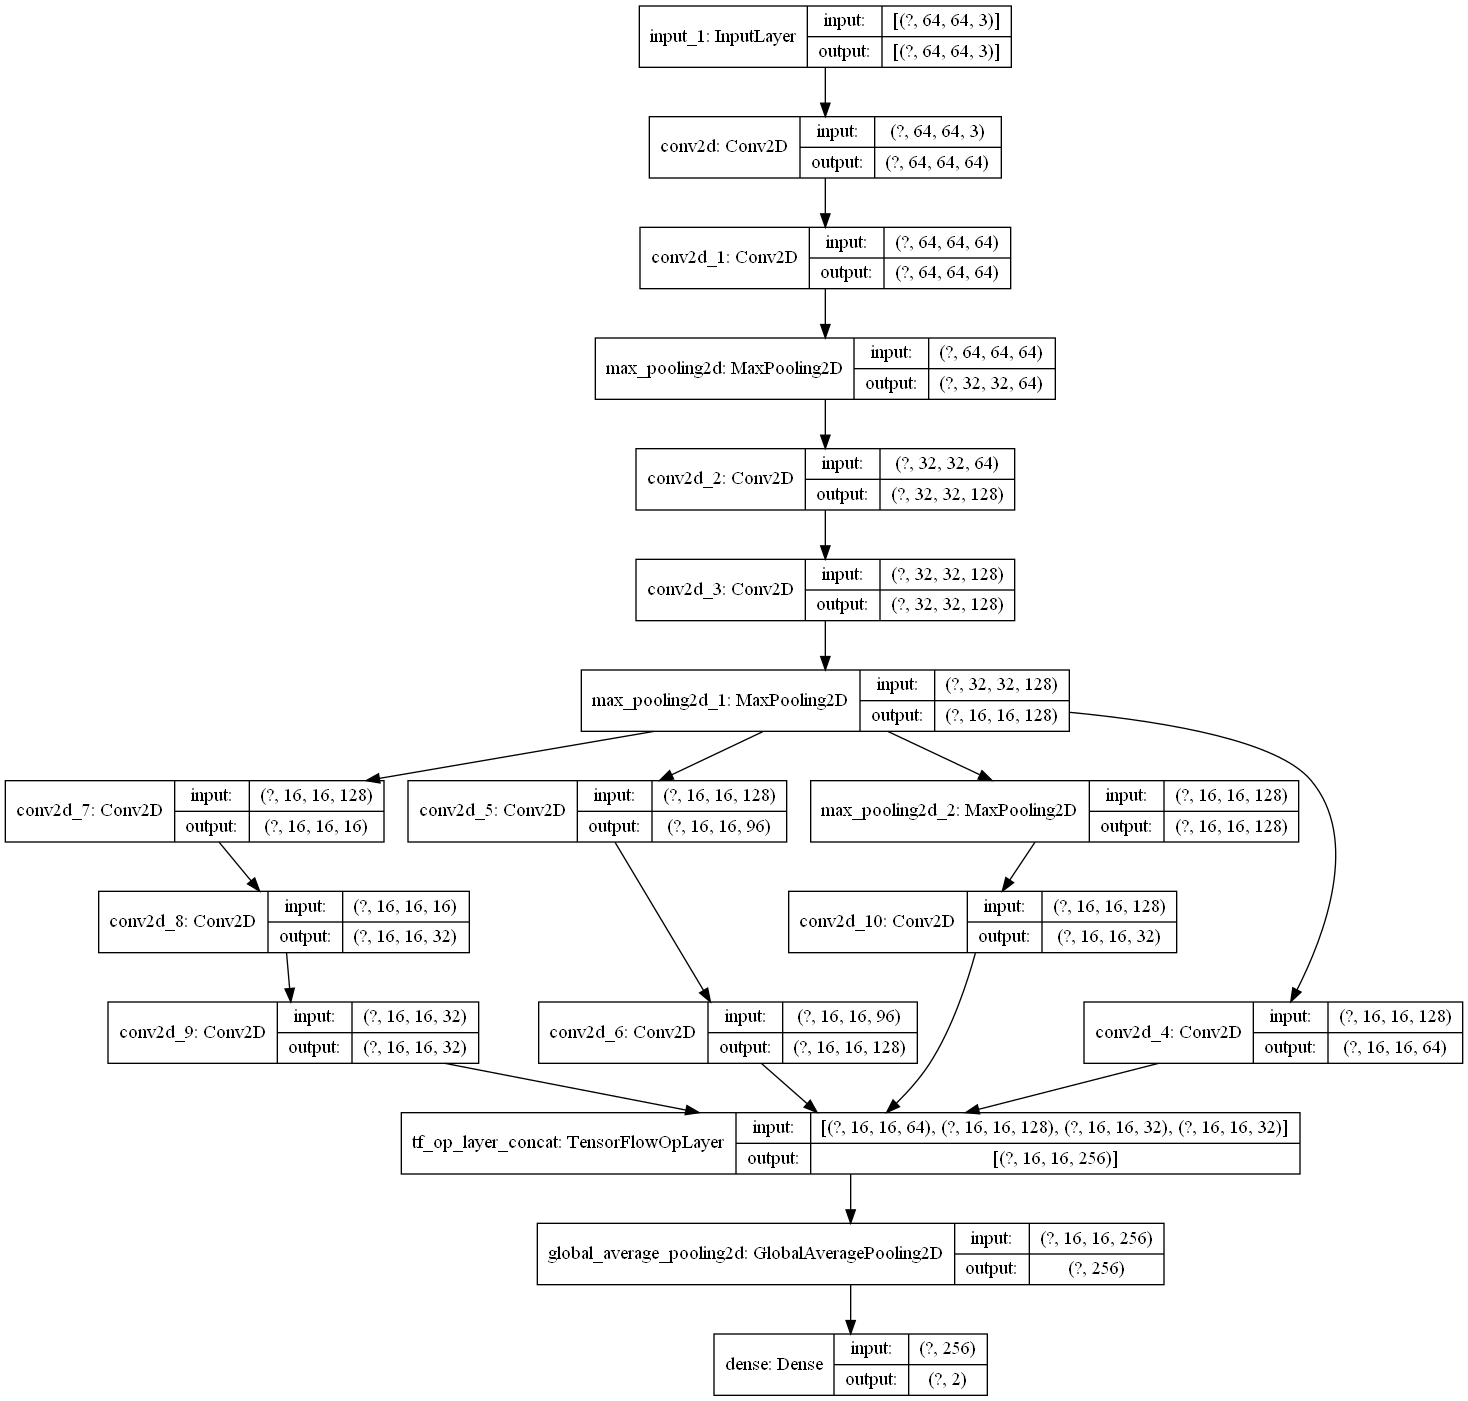

In [7]:
tf.keras.utils.plot_model(model,show_shapes=True)

In [8]:
from tensorflow.keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

In [9]:
history = model.fit(train_generator,
                    validation_data = val_generator,
                    epochs=40)

Epoch 1/40
203/203 [==============================] - 9s 46ms/step - loss: 0.7785 - accuracy: 0.5170 - val_loss: 0.6841 - val_accuracy: 0.5605
Epoch 2/40
203/203 [==============================] - 9s 43ms/step - loss: 0.6763 - accuracy: 0.5822 - val_loss: 0.7069 - val_accuracy: 0.5457
Epoch 3/40
203/203 [==============================] - 9s 43ms/step - loss: 0.6509 - accuracy: 0.6214 - val_loss: 0.6322 - val_accuracy: 0.6667
Epoch 4/40
203/203 [==============================] - 9s 43ms/step - loss: 0.6254 - accuracy: 0.6666 - val_loss: 0.6103 - val_accuracy: 0.6759
Epoch 5/40
203/203 [==============================] - 9s 45ms/step - loss: 0.6205 - accuracy: 0.6672 - val_loss: 0.6011 - val_accuracy: 0.6926
Epoch 6/40
203/203 [==============================] - 9s 46ms/step - loss: 0.6028 - accuracy: 0.6888 - val_loss: 0.5937 - val_accuracy: 0.7191
Epoch 7/40
203/203 [==============================] - 10s 47ms/step - loss: 0.5938 - accuracy: 0.7085 - val_loss: 0.5895 - val_accuracy: 0.695

Text(0.5, 1.0, 'real')

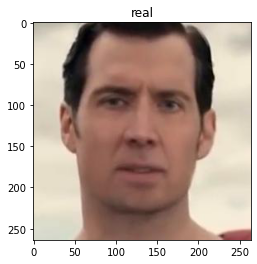

In [10]:
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from PIL import Image

img = image.load_img('dataset/test_images/fake/df2.jpg', target_size=(256,256))
img_1 = Image.open('dataset/test_images/fake/df2.jpg')
img = image.img_to_array(img)
img = np.expand_dims(img, axis = 0)

img2 = image.load_img('dataset/test_images/real/real00240.jpg', target_size=(256,256))
img_2 = Image.open('dataset/test_images/real/real00240.jpg')
img2 = image.img_to_array(img2)
img2 = np.expand_dims(img2, axis = 0)

classes = ['fake','real']

#print(classes[np.argmax(model.predict(img))])
#print(classes[np.argmax(model.predict(img2))])

plt.imshow(img_1)
plt.title(classes[np.argmax(model.predict(img))])

Text(0.5, 1.0, 'real')

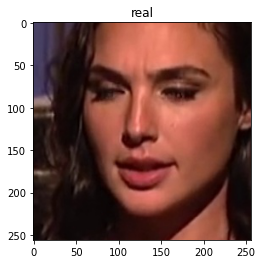

In [11]:
plt.imshow(img_2)
plt.title(classes[np.argmax(model.predict(img2))])

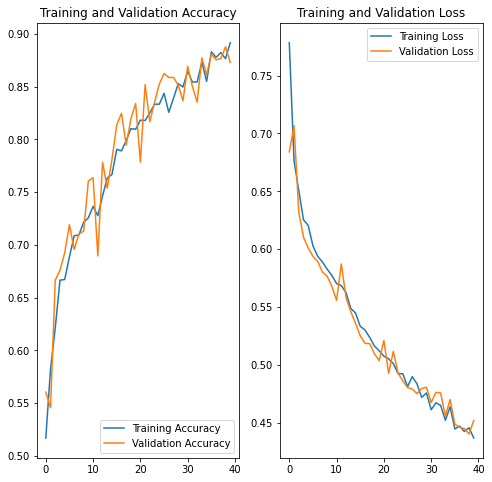

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(40)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()